#Importing

In [ ]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB

#Preparing Data

In [ ]:
train_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

print('Train size:', len(train_corpus.data))
print('Test size:', len(test_corpus.data))

Train size: 11314
Test size: 7532


In [ ]:
print('Labels:', train_corpus.target_names)

print('\nLabel encoding:', train_corpus.target)

print('\nExample article:', train_corpus.data[0])

Labels: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Label encoding: [7 4 4 ... 3 1 8]

Example article: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


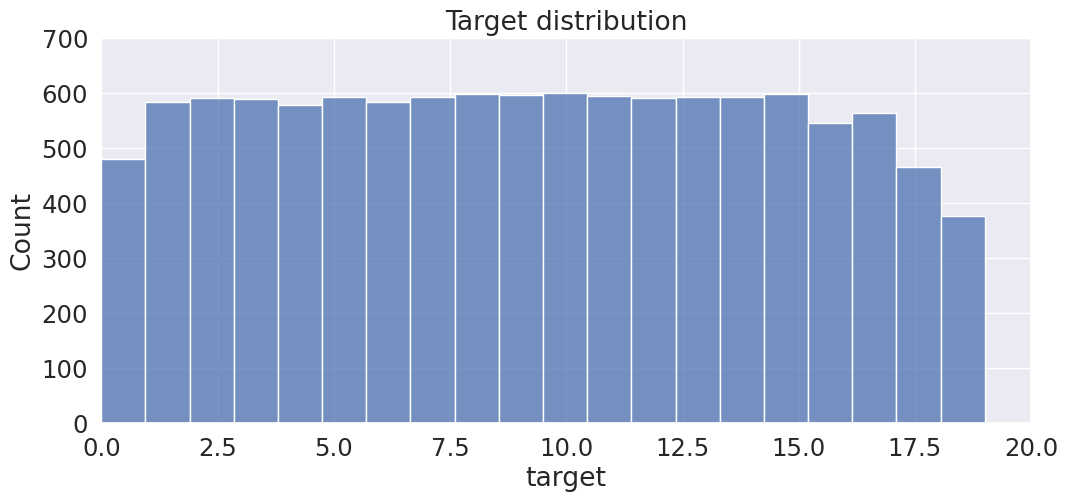

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(train_corpus, x = 'target', bins = 20)
plt.title('Target distribution')
plt.xlim(0,20)
plt.ylim(0,700)
plt.show()

#Pre_Precessing

In [ ]:
nlp = spacy.blank('en')

def custom_tokenizer(doc):
  return [t.text for t in nlp(doc) if not t.is_punct and not t.is_space and t.is_alpha]

#Vectorizer Data

In [ ]:
%%time

vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

x = vectorizer.fit_transform(train_corpus.data)
y = train_corpus.target

x_test = vectorizer.transform(test_corpus.data)
y_test = test_corpus.target

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 23.6 s, sys: 158 ms, total: 23.7 s
Wall time: 23.8 s


In [ ]:
%%time
clf = MultinomialNB()

clf.fit(x, y)

CPU times: user 52.7 ms, sys: 16.9 ms, total: 69.6 ms
Wall time: 76.1 ms


MultinomialNB()

In [ ]:
test_preds = clf.predict(x_test)

print('Test set F1_score: ', f1_score(y_test, test_preds, average='macro'))


Test set F1_score:  0.5751953553873447


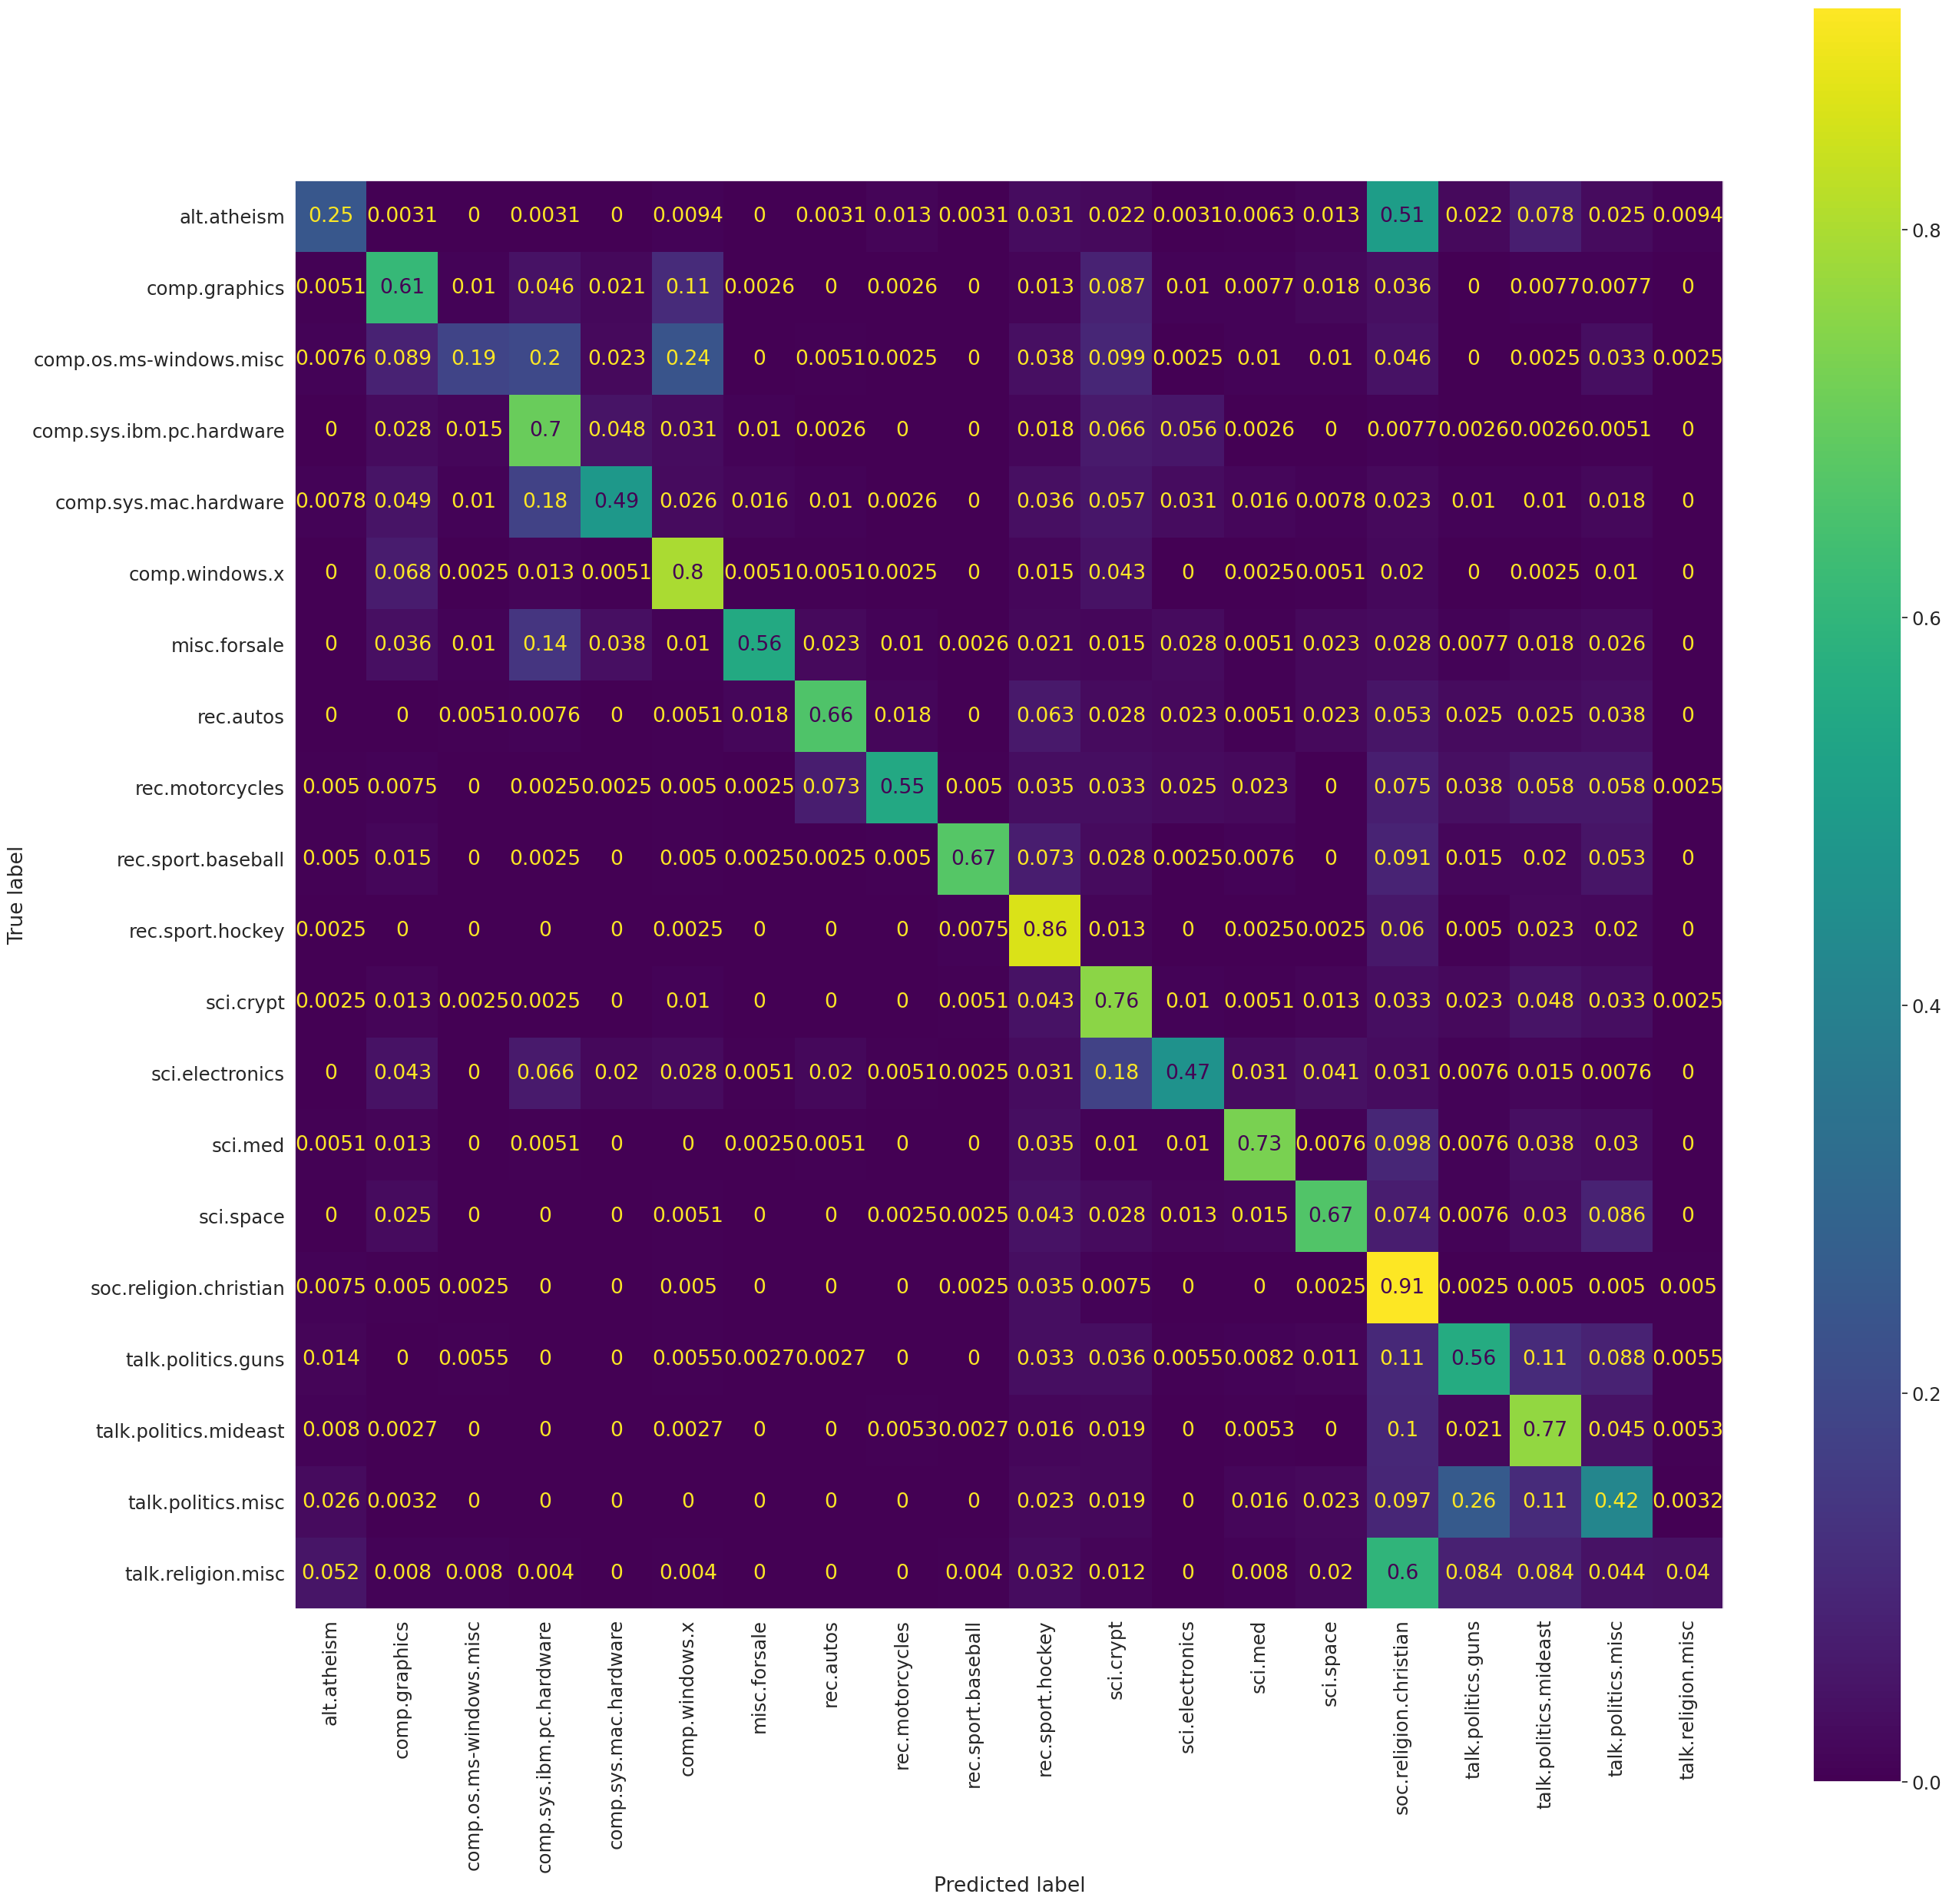

In [ ]:
fig, ax = plt.subplots(figsize = (30, 30))

ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, normalize = 'true', display_labels = train_corpus.target_names, xticks_rotation = 'vertical', ax = ax)

In [ ]:
print(classification_report(y_test, test_preds, target_names = train_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.25      0.35       319
           comp.graphics       0.60      0.61      0.61       389
 comp.os.ms-windows.misc       0.73      0.19      0.30       394
comp.sys.ibm.pc.hardware       0.51      0.70      0.59       392
   comp.sys.mac.hardware       0.75      0.49      0.59       385
          comp.windows.x       0.62      0.80      0.70       395
            misc.forsale       0.89      0.56      0.69       390
               rec.autos       0.81      0.66      0.73       396
         rec.motorcycles       0.89      0.55      0.68       398
      rec.sport.baseball       0.95      0.67      0.79       397
        rec.sport.hockey       0.59      0.86      0.70       399
               sci.crypt       0.49      0.76      0.60       396
         sci.electronics       0.68      0.47      0.55       393
                 sci.med       0.81      0.73      0.77       396
         

# Trying get better result by adding lemmatization and stop-word removal to our custom_tokenizer

In [ ]:
nlp = spacy.load('en_core_web_sm')

unwanted_pipes = ['ner', 'parser']

def custom_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space and not t.is_stop and t.is_alpha]


In [ ]:
%%time

vectorizer = TfidfVectorizer(tokenizer = custom_tokenizer)

x = vectorizer.fit_transform(train_corpus.data)
y = train_corpus.target

x_test = vectorizer.transform(test_corpus.data)
y_test = test_corpus.target

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 4min 11s, sys: 3.86 s, total: 4min 15s
Wall time: 4min 15s


In [ ]:
%%time

grid = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}

clf = MultinomialNB()

model = GridSearchCV(clf, param_grid = grid, scoring = 'f1_macro', n_jobs = -1, cv = 5, verbose = 5)

model.fit(x, y)

print('Best parameters: ', model.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters:  {'alpha': 0.01}
CPU times: user 116 ms, sys: 56.1 ms, total: 172 ms
Wall time: 3.47 s


In [ ]:
test_preds = model.predict(x_test)

print('Test set F1-score:', f1_score(y_test, test_preds, average='macro'))

Test set F1-score: 0.6760619325470159


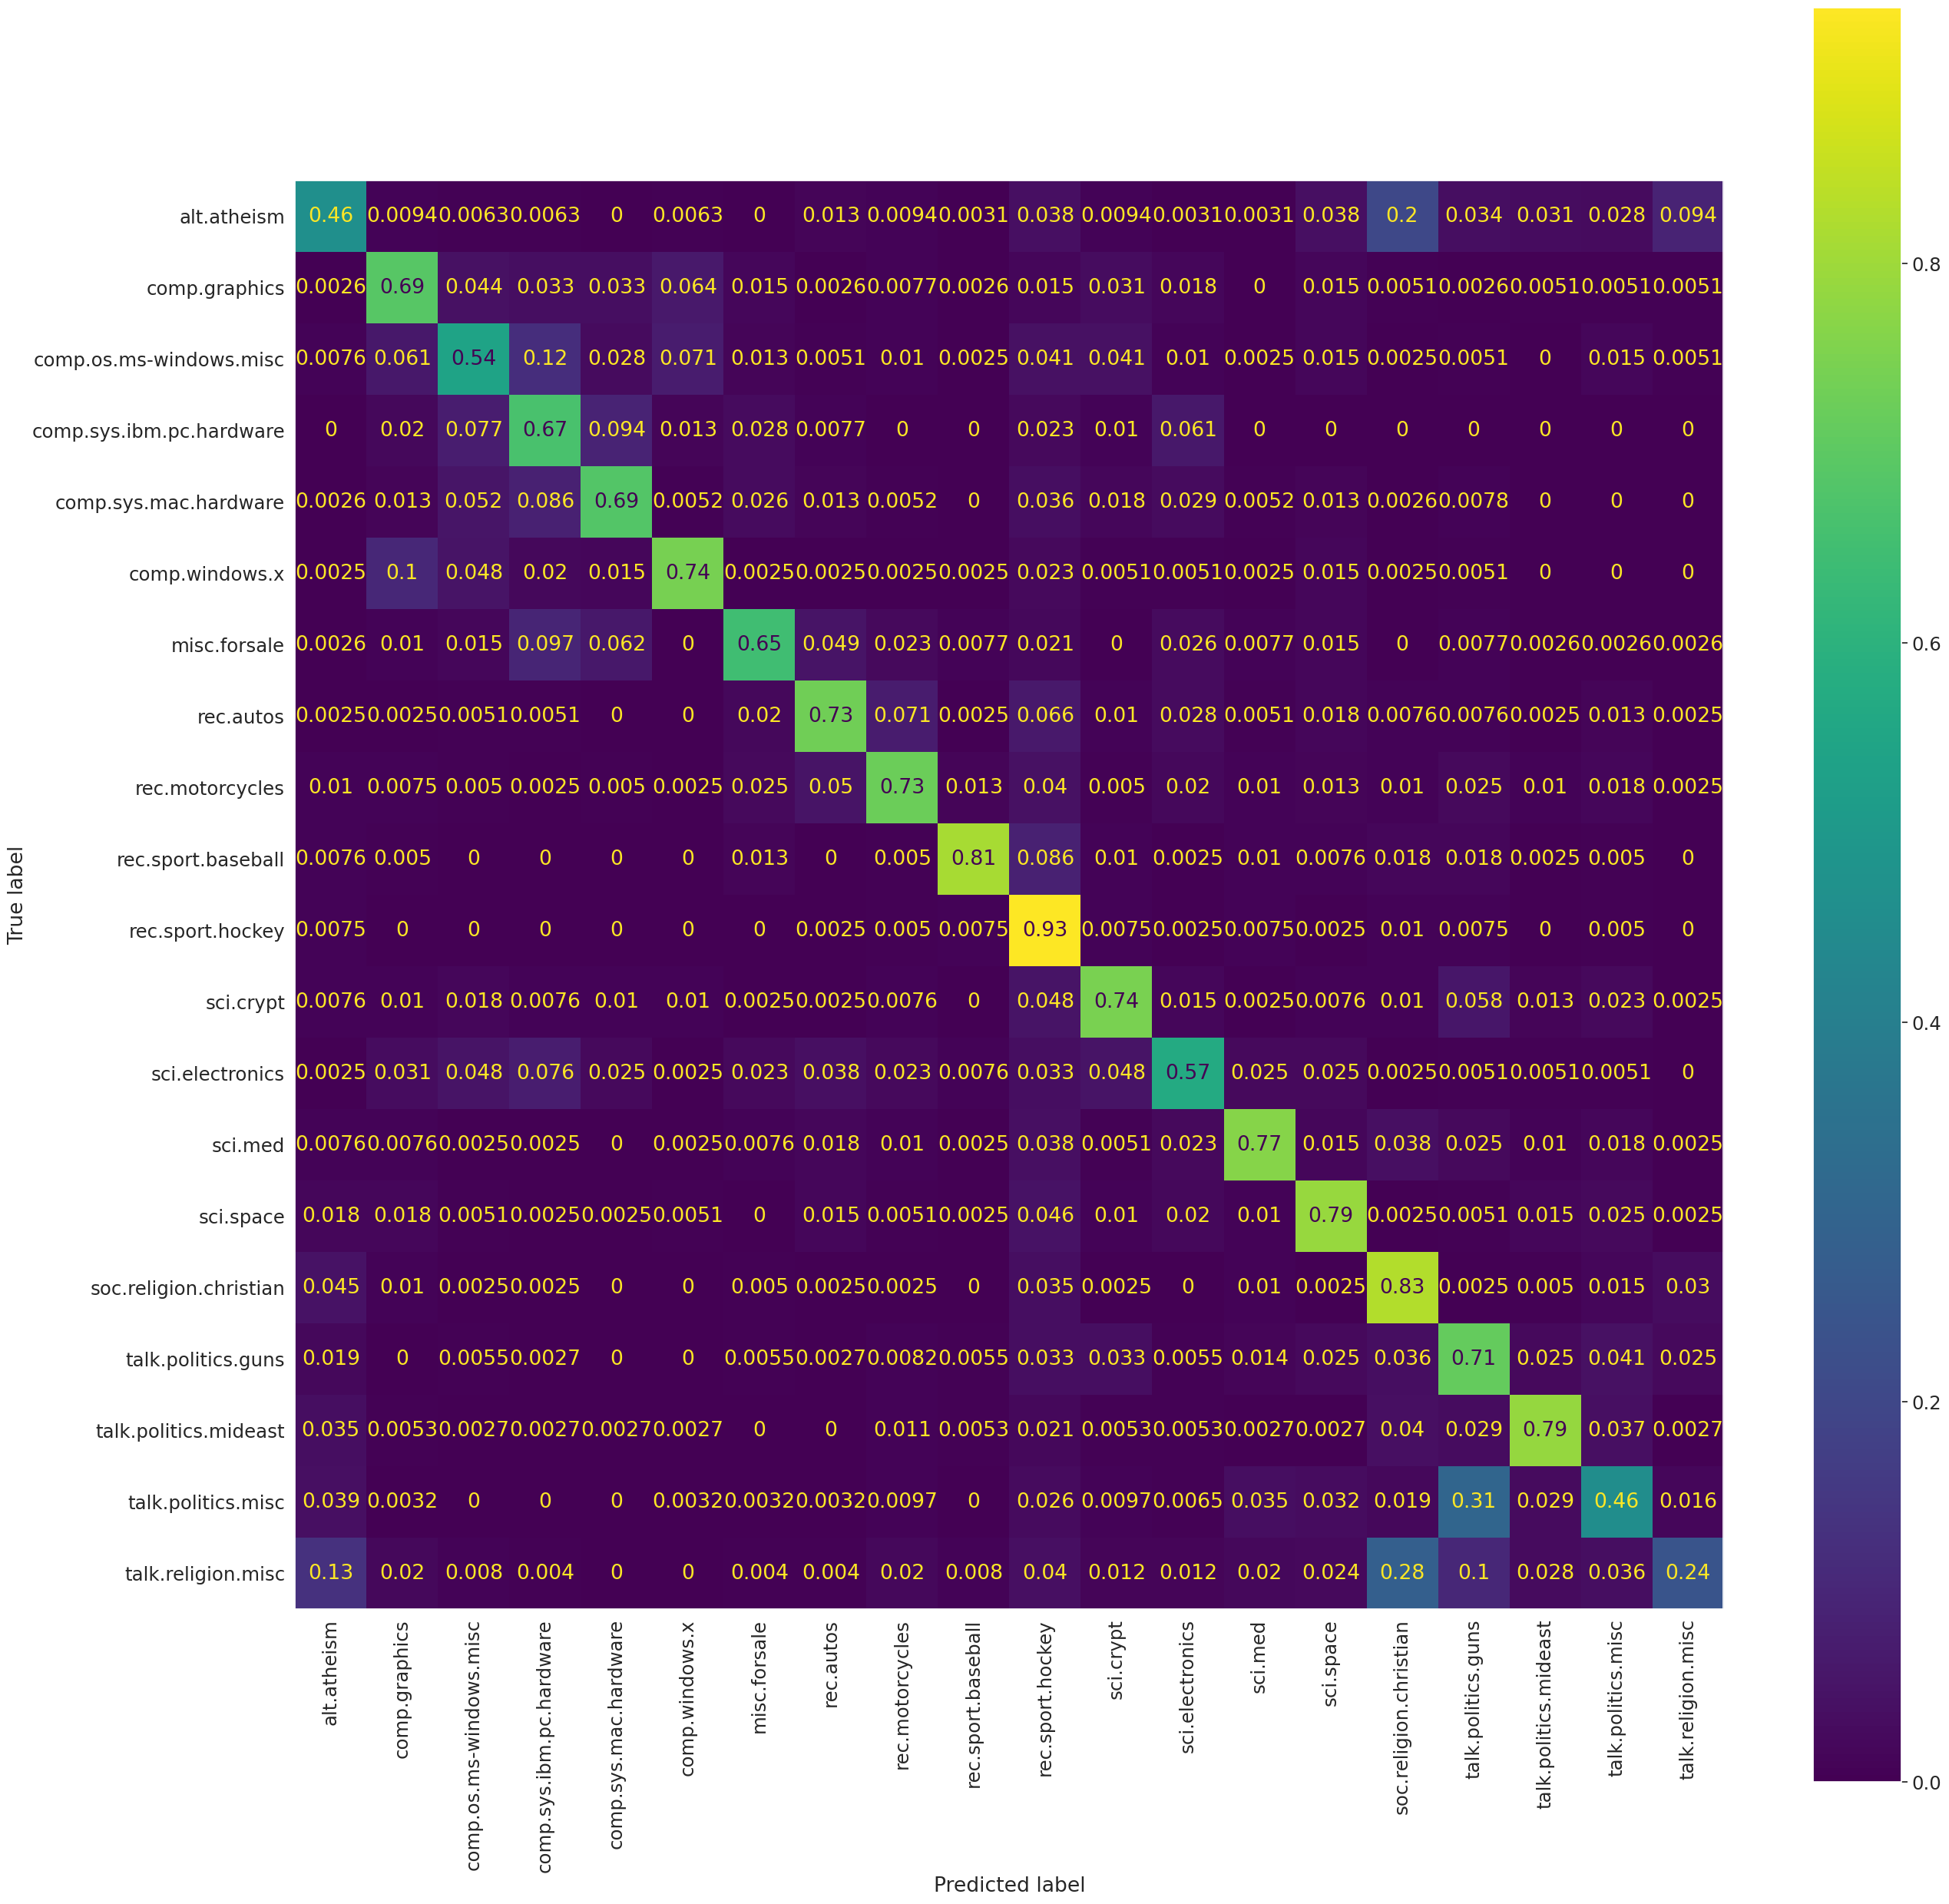

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.grid(False)

disp = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize='true', display_labels=train_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [ ]:
print(classification_report(y_test, test_preds, target_names=train_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.46      0.51       319
           comp.graphics       0.68      0.69      0.68       389
 comp.os.ms-windows.misc       0.62      0.54      0.58       394
comp.sys.ibm.pc.hardware       0.59      0.67      0.62       392
   comp.sys.mac.hardware       0.71      0.69      0.70       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.77      0.65      0.70       390
               rec.autos       0.77      0.73      0.75       396
         rec.motorcycles       0.77      0.73      0.75       398
      rec.sport.baseball       0.92      0.81      0.86       397
        rec.sport.hockey       0.58      0.93      0.72       399
               sci.crypt       0.74      0.74      0.74       396
         sci.electronics       0.67      0.57      0.62       393
                 sci.med       0.83      0.77      0.80       396
         

In [ ]:
article = ["Nasa's Swot satellite will survey millions of rivers and lakes"]

X_article = vectorizer.transform(article)

proba_article = model.predict_proba(X_article)

id_max = np.argmax(proba_article)
pred_article = train_corpus.target_names[id_max]
conf = np.max(proba_article)

print('Prediction:', pred_article)
print('Confidence:', conf)

Prediction: sci.space
Confidence: 0.9370717756296342
